In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
X, y = skds.fetch_openml("vehicleNorm", return_X_y=True)
y[y==['1']] = 1
y[y==['-1']] = 0
X = X.toarray()
X = StandardScaler().fit_transform(X)


In [7]:
x_neg=X[y==0]
x_pos=X[y==1]

In [8]:
np.random.shuffle(x_neg)
x_test=x_neg[0:24632]
x_train=x_neg[24632:49264]
x_train=np.concatenate((x_train,x_pos))
y_train=np.concatenate((np.zeros(24632),np.ones(49264)))
y_test=np.zeros(24632)

# Projection model

In [9]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [10]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [11]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,6000,6000,50,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(49264, 100)
Size: 6000 Bits - FPR: 0.876218 - Time Taken to create filter(sec): 14.322299 



Size: 12000 Bits - FPR: 0.806918 - Time Taken to create filter(sec): 13.827241 



Size: 18000 Bits - FPR: 0.755237 - Time Taken to create filter(sec): 13.556781 



Size: 24000 Bits - FPR: 0.695193 - Time Taken to create filter(sec): 13.679482 



Size: 30000 Bits - FPR: 0.697020 - Time Taken to create filter(sec): 13.590816 



Size: 36000 Bits - FPR: 0.635352 - Time Taken to create filter(sec): 14.096801 



Size: 42000 Bits - FPR: 0.595567 - Time Taken to create filter(sec): 13.757626 



Size: 48000 Bits - FPR: 0.569138 - Time Taken to create filter(sec): 13.255111 



Size: 54000 Bits - FPR: 0.589437 - Time Taken to create filter(sec): 13.687437 



Size: 60000 Bits - FPR: 0.503045 - Time Taken to create filter(sec): 13.558891 



Size: 66000 Bits - FPR: 0.508241 - Time Taken to create filter(sec): 13.416628 



Size: 72000 Bits - FPR: 0.485872 - Time Tak

Size: 288000 Bits - FPR: 0.095283 - Time Taken to create filter(sec): 23.870483 



Size: 294000 Bits - FPR: 0.091385 - Time Taken to create filter(sec): 23.847408 



Size: 300000 Bits - FPR: 0.092684 - Time Taken to create filter(sec): 23.731059 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

(49264, 100)
Size: 6000 Bits - FPR: 0.842116 - Time Taken to create filter(sec): 13.692126 



Size: 12000 Bits - FPR: 0.828150 - Time Taken to create filter(sec): 14.989990 



Size: 18000 Bits - FPR: 0.724586 - Time Taken to create filter(sec): 13.433572 



Size: 24000 Bits - FPR: 0.714437 - Time Taken to create filter(sec): 13.631504 



Size: 30000 Bits - FPR: 0.687967 - Time Taken to create filter(sec): 13.601258 



Size: 36000 Bits - FPR: 0.624066 - Time Taken to create filter(sec): 13.477692 



Size: 42000 Bits - FPR: 0.592603 - Time Taken to create filter(sec): 13.482595 



Size: 48000 Bits - FPR: 0.599911 - Time Taken to create filter(sec): 13.192669 



Size: 54000 Bits - FPR: 0.492408 - Time 

In [12]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

50


In [13]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

50


# Normal Bloom Filter Values

In [14]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [15]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

150
49264.0


# FPR Comparison between Projection Model and Normal Bloom Filter

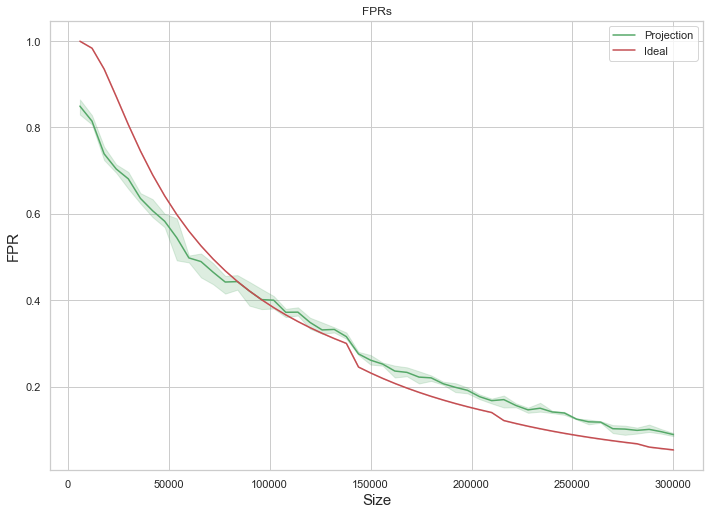

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [17]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

150


In [18]:
average_times = num_of_iterations*average_times
print(len(average_times))

150


In [19]:
print(average_fprs)

[0.8493964490635487, 0.8146313738226697, 0.7390251163797771, 0.70388113023709, 0.6810246833387463, 0.6358124932337339, 0.6073941755981379, 0.5829679549637328, 0.5447114864133377, 0.4980513153621306, 0.48960701526469635, 0.46504546930821694, 0.442243152538703, 0.44324455992205264, 0.42129479268160663, 0.40160495831980086, 0.40018404243802097, 0.37222583089747757, 0.3725100140738335, 0.3487739525820072, 0.3313846486954639, 0.33253491393309514, 0.31582223665692327, 0.27595539677384434, 0.26135379452203095, 0.25231406300747, 0.23622388221283966, 0.23311139980513151, 0.22217711378153082, 0.2204449496589802, 0.20677709212947926, 0.19854931254736385, 0.19158005846053913, 0.17685666341885894, 0.1676545415178088, 0.17007686478293818, 0.15646313738226697, 0.14632727075890442, 0.15017050990581357, 0.1414555591642308, 0.13907383349572372, 0.12498646746779257, 0.1186532423947169, 0.11793601818772327, 0.10273898451878316, 0.101845837393093, 0.098895745371874, 0.10119627584713653, 0.09583739309299555

In [21]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,6000,0.999728,0.876218,0.849396,14.322299,13.852797
1,12000,0.983518,0.806918,0.814631,13.827241,14.097799
2,18000,0.935233,0.755237,0.739025,13.556781,13.552375
3,24000,0.871613,0.695193,0.703881,13.679482,13.605986
4,30000,0.806439,0.697020,0.681025,13.590816,13.495518


In [22]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/SatLog_rerun_epochs_100.csv')